In [0]:
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import os

In [3]:
#!pip install dgl

     |████████████████████████████████| 3.0MB 4.4MB/s 


In [4]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [0]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [0]:
class GCNLSTM(nn.Module):
  def __init__(self, n_feats, seq_len):
    super(GCNLSTM, self).__init__()
    self.n_feats = n_feats
    self.seq_len = seq_len
    self.n_hidden = 10 # number of hidden states for LSTM cell
    self.n_layers = 3 # number of stacked LSTM layers

    self.lstm = nn.LSTM(input_size=n_feats,
                        hidden_size=self.n_hidden,
                        num_layers=self.n_layers,
                        batch_first=True,
                        dropout=0.3)
    
  def forward(self, g, feature):
    with g.local_scope():
      g.ndata['h'] = feature
      g.update_all(gcn_msg, gcn_reduce)
      h = g.ndata['h']
      return self.lstm(h)[0]

In [0]:
class GCNLinear(nn.Module):
  def __init__(self, in_feats, out_feats):
    super(GCNLinear, self).__init__()
    self.linear = nn.Linear(in_feats, out_feats)

  def forward(self, g, feature):
    with g.local_scope():
      g.ndata['h'] = feature
      g.update_all(gcn_msg, gcn_reduce)
      h = g.ndata['h']
      return self.linear(h)


In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.layer1 = GCNLSTM(2, 10)
    self.dropout1 = nn.Dropout(0.3)
    self.layer2 = GCNLinear(100, 50)
    self.layer3 = GCNLinear(50, 2)

  def forward(self, g, features):
    batch_size, seq_len, n_feats = features.size()

    x = self.layer1(g, features)
    x = x.contiguous().view(batch_size, -1) # flatten
    x = F.relu(self.layer2(g, x))
    x = F.sigmoid(self.layer3(g, x))
    return x

In [0]:
def load_data(file):
  with open(f'model_ready_data/{file}', 'rb') as f:
    C, features, targets = pickle.load(f)
  features = th.FloatTensor(features)
  targets = th.FloatTensor(targets)
  g = dgl.DGLGraph()
  g.from_networkx(C)
  return g, features, targets

In [13]:
th.manual_seed(0)
net = Net()
print(net)

Net(
  (layer1): GCNLSTM(
    (lstm): LSTM(2, 10, num_layers=3, batch_first=True, dropout=0.3)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): GCNLinear(
    (linear): Linear(in_features=100, out_features=50, bias=True)
  )
  (layer3): GCNLinear(
    (linear): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [0]:
train_files = []
test_files = []
for file in os.listdir('model_ready_data'):
  date = dt.datetime.strptime(file[:-4], '%Y-%m-%d')
  if date < dt.datetime.strptime('2020-05-01', '%Y-%m-%d'):
    train_files.append(file)
  else:
    test_files.append(file)

In [15]:
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
n_epochs = 500
train_loss = []
test_loss = []
for epoch in range(n_epochs):
  train_loss_epoch = []
  test_loss_epoch = []
  for file in train_files:
    g, features, targets = load_data(file)
    
    net.train()
    pred = net(g, features)
    loss = F.mse_loss(pred, targets)
    train_loss_epoch.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  for file in test_files:
    g, features, targets = load_data(file)
    pred = net(g, features)
    loss = F.mse_loss(pred, targets)
    test_loss_epoch.append(loss.item())

  train_loss.append(np.mean(train_loss_epoch))
  test_loss.append(np.mean(test_loss_epoch))

  if epoch % 50 == 0:
    print(f'Epoch: {epoch}, Train Loss: {train_loss[epoch]}, Test Loss: {test_loss[epoch]}')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, Train Loss: 0.07820454409552945, Test Loss: 0.5894531644880772
Epoch: 50, Train Loss: 0.00970830257891243, Test Loss: 0.04629794554784894
Epoch: 100, Train Loss: 0.008024727045835591, Test Loss: 0.030350270215421915
Epoch: 150, Train Loss: 0.0074519811005553625, Test Loss: 0.024382296949625015
Epoch: 200, Train Loss: 0.007200852012812654, Test Loss: 0.02657578676007688
Epoch: 250, Train Loss: 0.0066009681991637, Test Loss: 0.026102680480107665
Epoch: 300, Train Loss: 0.006415010495448333, Test Loss: 0.023695160169154406
Epoch: 350, Train Loss: 0.006274318284090046, Test Loss: 0.02564489166252315
Epoch: 400, Train Loss: 0.005919185485521912, Test Loss: 0.026290472131222486
Epoch: 450, Train Loss: 0.005777421887386719, Test Loss: 0.024667630554176867


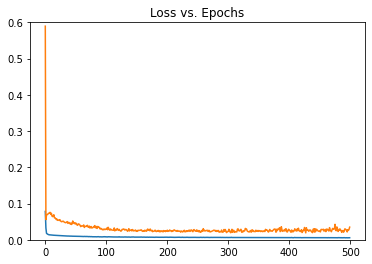

In [16]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Loss vs. Epochs')
plt.ylim((0,0.6))
plt.show()

In [0]:
# forecast
def one_day_forecast(g, features):
  pred = net(g, features)
  new_features = th.zeros(features.size())
  new_features[:,0:9,:] = features[:,1:10,:]
  new_features[:,9,:] = pred
  return pred, new_features

def several_day_forecast(g, features, n_days):
  new_features = features
  for i in range(n_days):
    pred, new_features = one_day_forecast(g, new_features)
  return pred, new_features

In [18]:
g, features, targets = load_data('2020-05-01.pkl')
pred, new_features = several_day_forecast(g, features, 7)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
g, true_features, targets = load_data('2020-05-08.pkl')

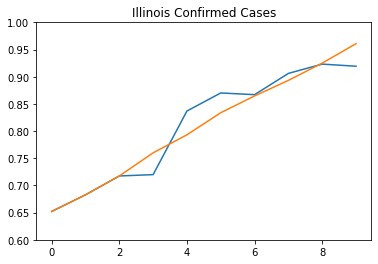

In [25]:
# look at illinois as example (14 is index of illinois)
plt.plot(new_features[14,:,0].detach().numpy())
plt.plot(true_features[14,:,0].detach().numpy())
plt.title('Illinois Confirmed Cases')
plt.ylim((0.6,1))
plt.show()